# Brain Tumor recognition using DWT and CNN

In [22]:
import torch
from torch import nn
import numpy as np
from PIL import Image
import cv2
import pywt
from torchvision import transforms, datasets, models
import os
from torch.utils.data import Subset, ConcatDataset, random_split, DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Importing dataset

In [23]:
# !pip install kaggle -q

# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle

# !kaggle datasets download -d ahmedhamada0/brain-tumor-detection

# !unzip -qo brain-tumor-detection.zip
# !mkdir data
# !cp -r yes data
# !cp -r no data
# !rm -r no
# !rm -r yes


# !kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection
# !unzip -qo brain-mri-images-for-brain-tumor-detection.zip
# !rm -r no
# !rm -r yes

/bin/bash: /home/ubuntu/.venv/bin/pip: /home/ubuntu/tihan/tihan_eir/venv_tihan/bin/python3: bad interpreter: No such file or directory


mkdir: cannot create directory ‘/home/ubuntu/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
/bin/bash: /home/ubuntu/.venv/bin/kaggle: /home/ubuntu/tihan/tihan_eir/venv_tihan/bin/python3: bad interpreter: No such file or directory
mkdir: cannot create directory ‘data’: File exists
/bin/bash: /home/ubuntu/.venv/bin/kaggle: /home/ubuntu/tihan/tihan_eir/venv_tihan/bin/python3: bad interpreter: No such file or directory


## Wavelet and preprocessing functions

In [24]:
def haar_wavelet(img, wav_type='haar'):
    img_arr = np.array(img)
    coeffs = pywt.dwt2(img_arr, wav_type)
    LL, (LH, HL, HH) = coeffs

    feature_vector = np.stack((LL, LH, HL, HH), axis=-1).astype(np.float32)
    return feature_vector

def hist_equalize(image):
    equalized_image = cv2.equalizeHist(np.array(image))
    return Image.fromarray(equalized_image).convert('L')

def hist_equalize_open(image):
    image = np.array(image)
    equalized_image = cv2.equalizeHist(image)
    close_oper = cv2.morphologyEx(equalized_image, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))
    return Image.fromarray(close_oper).convert('L')

## Model and training function definition 

In [29]:
# model definition
initial_model = models.resnet101(weights='DEFAULT')

num_classes = 2
initial_model.fc = nn.Linear(initial_model.fc.in_features, num_classes)
initial_model.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
initial_model = initial_model.to(device)

model = initial_model


transform = transforms.Compose([
        transforms.Resize((448, 448)),
        transforms.Grayscale(),
        transforms.Lambda(hist_equalize_open),
        transforms.Lambda(haar_wavelet),
        transforms.ToTensor(),
        transforms.Normalize(mean=[71.7513, -0.0043, 0.002, -0.0003], std=[78.8939, 6.2766, 7.2413, 1.6252])
    ])

# training function
def train(model, train_dataloader, test_dataloader, num_epochs=10, criterion=nn.CrossEntropyLoss(), lr=0.001, optimizer_type='Adam'):

    optimizer_class = getattr(torch.optim, optimizer_type)
    optimizer = optimizer_class(model.parameters(),lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)


    train_accuracy_arr = [accuracy(model, train_dataloader)]
    
    loss_arr = []
    test_accuracy_arr = [accuracy(model, test_dataloader)]
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
        
        scheduler.step()
        # Print average loss per epoch
        epoch_loss = running_loss / len(train_dataloader.dataset)
        loss_arr.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
        train_accuracy_arr.append(accuracy(model, train_dataloader))
        test_accuracy_arr.append(accuracy(model, test_dataloader))
        print(test_accuracy_arr[-1])
        print(train_accuracy_arr[-1])

    return train_accuracy_arr, test_accuracy_arr, loss_arr


# accuracy function
def accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

def confusion_matrix(model, data_loader):

    model.eval()
    confusion_matrix = np.zeros((2, 2))

    with torch.no_grad():
        
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            confusion_matrix[0][0] += torch.sum((predicted == 1) & (labels == 1)).item()
            confusion_matrix[0][1] += torch.sum((predicted == 1) & (labels == 0)).item()
            confusion_matrix[1][0] += torch.sum((predicted == 0) & (labels == 1)).item()
            confusion_matrix[1][1] += torch.sum((predicted == 0) & (labels == 0)).item()

    return confusion_matrix

In [ ]:
augmentation_transform = transforms.Compose([
        transforms.Resize((448, 448)),
        transforms.Grayscale(),
        transforms.Lambda(hist_equalize_open),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0)),
        transforms.RandomAffine(degrees=0, translate=(0, 0.2)),
        transforms.RandomAffine(degrees=0, shear=(0, 30)),
        transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.Lambda(hist_equalize_open),
        transforms.Lambda(haar_wavelet),
        transforms.ToTensor(),
        transforms.Normalize(mean=[71.7513, -0.0043, 0.002, -0.0003], std=[78.8939, 6.2766, 7.2413, 1.6252])
    ])


train_data_dir = 'Training'
test_data_dir = 'Testing'

original_dataset = datasets.ImageFolder(root=train_data_dir, transform=transform)
augmented_dataset = datasets.ImageFolder(root=train_data_dir, transform=augmentation_transform)

num_augmented_samples = int(0.5 * len(augmented_dataset))
indices = np.random.choice(range(len(augmented_dataset)), num_augmented_samples)

augmented_subset = Subset(augmented_dataset, indices)

train_dataset = ConcatDataset([original_dataset, augmented_subset])

test_dataset = datasets.ImageFolder(root=test_data_dir, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

train_dataset = datasets.ImageFolder(root=train_data_dir, transform=transform)
class_counts = [0] * len(train_dataset.classes)
for _, label in train_dataset.samples:
    class_counts[label] += 1

class_weights = [1 / count for count in class_counts]
sampler = WeightedRandomSampler(class_weights, len(train_dataset), replacement=True)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)


output = train(model, train_dataloader, test_dataloader, num_epochs=10, criterion=nn.CrossEntropyLoss(), lr=0.001, optimizer_type='Adam')


train_confusion_mat = confusion_matrix(model, train_dataloader)
test_confusion_mat = confusion_matrix(model, test_dataloader)


In [ ]:
np.savez('lists.npz', train_arr=output[0], test_arr=output[1], loss=output[2], train_conf=train_confusion_mat, test_conf=test_confusion_mat)

## Results

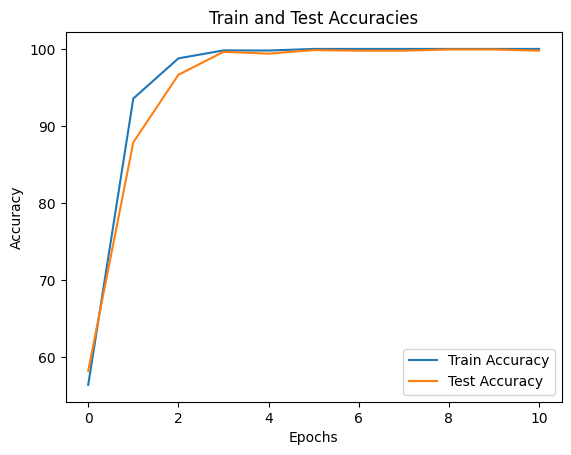

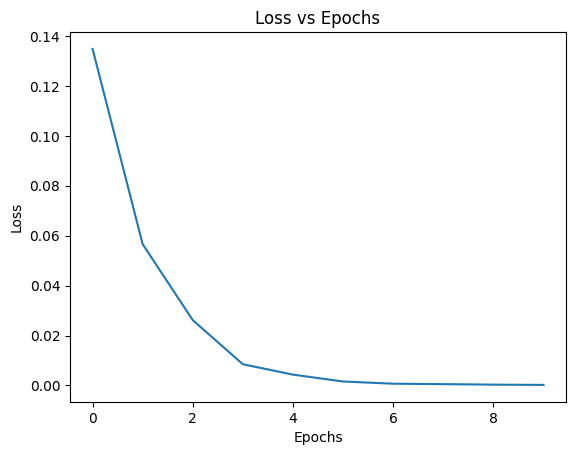

Train Accuracy: 100.0
Test Accuracy: 99.77116704805492
Train:

	recall: 1.0
	precision: 1.0
	f1-score: 1.0
Test:

	recall: 1.0
	precision: 0.9966887417218543
	f1-score: 0.9983416252072967


In [2]:
import numpy as np
import matplotlib.pyplot as plt

data2 = np.load('haar_histopen.npz')

plt.plot(range(len(data2['train_arr'])), data2['train_arr'], label='Train Accuracy')
plt.plot(range(len(data2['test_arr'])), data2['test_arr'], label='Test Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracies')
plt.legend()
plt.show()

plt.plot(range(len(data2['loss'])), data2['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.show()

train_accuracy = data2['train_arr'][-1]
test_accuracy = data2['test_arr'][-1]

# Print the accuracies
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

train_confusion_mat = data2['train_conf']
test_confusion_mat = data2['test_conf']

name = ['Train', 'Test']

for i, confusion_mat in enumerate([train_confusion_mat, test_confusion_mat]):
    print(f'{name[i]}:\n')
    recall = confusion_mat[0, 0] / (confusion_mat[0, 0] + confusion_mat[0, 1])
    precision = confusion_mat[0, 0] / (confusion_mat[0, 0] + confusion_mat[1, 0])
    print(f'\trecall: {recall}')
    print(f'\tprecision: {precision}')
    print(f'\tf1-score: {(2 * precision * recall) / (precision + recall)}')

In [ ]:
torch.save(model.state_dict(), 'final_model4.pth')